In [2]:
%cd ../data/external
!if [ ! -e "CubiCasa5k" ]; then git clone "https://github.com/CubiCasa/CubiCasa5k.git"; fi
%cd CubiCasa5k

!pip install lmdb
!pip install svgpathtools

/home/xfaron/Desktop/Code/Playground/test_construction/data/external
/home/xfaron/Desktop/Code/Playground/test_construction/data/external/CubiCasa5k


In [3]:
import cv2
import numpy as np
import torch
from floortrans.loaders.house import House
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt

# Dataset Definition

In [ ]:
from typing import List
import os

from torch.utils.data import Dataset
from torchvision.ops.boxes import masks_to_boxes, box_area

from tqdm import tqdm
import warnings
import gc

warnings.filterwarnings(
    "ignore", message="libpng warning: iCCP: known incorrect sRGB profile"
)


class WallSegPreprocess:
    def __init__(
        self,
        data_folder: str,
        img_folders: List[str],
        destination_folder: str,
        tensor_name: str,
        crop_size: int = 512,
        overlap: int = 64,  # Overlap between tiles
        min_content_ratio: float = 0.1,  # Minimum ratio of non-white pixels to keep tile
    ):
        self.data_folder = data_folder
        self.img_folders = img_folders
        self.crop_size = crop_size
        self.overlap = overlap
        self.min_content_ratio = min_content_ratio
        self.destination_folder = destination_folder
        self.tensor_name = tensor_name

        self.transform = transforms.ToTensor()

        self.img_file_name = "F1_scaled.png"
        self.svg_file_name = "model.svg"

        self.processed = False
        self.processed_img_dir = os.path.join(self.destination_folder, "images")
        self.processed_mask_dir = os.path.join(self.destination_folder, "masks")
        self.processed_img_path = os.path.join(self.processed_img_dir, "img_{}.npy")
        self.processed_mask_path = os.path.join(self.processed_mask_dir, "mask_{}.npy")

        # Store list of image paths instead of tiles
        self.img_paths = []
        for img_folder in tqdm(img_folders, desc="Indexing images"):
            img_path = os.path.join(
                self.data_folder, img_folder[1:], self.img_file_name
            )
            self.img_paths.append(img_path)

    def __len__(self):
        return len(self.img_paths)

    def _is_tile_valid(self, img_tile, mask_tile):
        """
        Check if a tile contains enough content to be worth keeping.
        Returns True if the tile should be kept, False otherwise.
        """
        # Check mask first (faster) - if mask has any walls, keep it
        if np.any(mask_tile > 0):
            return True

        # Check image content - count non-white pixels (assuming white is padding/empty)
        # In normalized space, white is close to 1.0
        non_white_pixels = np.sum(img_tile < 0.95)  # Adjust threshold as needed
        total_pixels = img_tile.size
        content_ratio = non_white_pixels / total_pixels

        return content_ratio >= self.min_content_ratio

    def __getitem__(self, index):
        """
        Loads the image and mask
        """
        return np.load(self.processed_img_path.format(index)), np.load(
            self.processed_mask_path.format(index)
        )

    def __pre_process_case(self, index):
        """
        Returns all tiles for a single image as tensors.
        Returns: (img_tiles, mask_tiles) where each is a tensor of shape [N, C, H, W]
        """
        img_path = self.img_paths[index]

        # Read and preprocess the image once
        original_img = cv2.imread(img_path)
        if original_img is None:
            raise ValueError(f"Invalid image at {img_path}")

        height, width, _ = original_img.shape

        # Preprocess image once
        img = self.__pre_process_img(original_img)

        # Get mask once
        house = House(
            os.path.join(os.path.dirname(img_path), self.svg_file_name),
            height,
            width,
        )
        mask = self.__get_mask(house)
        del houseblur = cv2.GaussianBlur(img, (5, 5), 0)
        sharpened = cv2.addWeighted(img, 1.5, blur, -0.5, 0)
        img = sharpened

        # Generate tiles with overlap
        img_tiles = []
        mask_tiles = []

        # Calculate stride (step size between tiles)
        stride = self.crop_size - self.overlap

        # If the whole image fits in one tile
        if height <= self.crop_size and width <= self.crop_size:
            # Pad to crop_size if needed
            img_padded = np.ones((self.crop_size, self.crop_size), dtype=img.dtype)
            mask_padded = np.zeros((self.crop_size, self.crop_size), dtype=mask.dtype)

            img_padded[:height, :width] = img
            mask_padded[:height, :width] = mask

            img_tiles.append(img_padded[np.newaxis, ...])
            mask_tiles.append(mask_padded[np.newaxis, ...])
        else:
            # Generate overlapping tiles
            y_positions = list(range(0, height, stride))
            x_positions = list(range(0, width, stride))

            # Ensure we cover the entire image by adjusting last positions
            if y_positions[-1] + self.crop_size < height:
                y_positions.append(height - self.crop_size)
            if x_positions[-1] + self.crop_size < width:
                x_positions.append(width - self.crop_size)

            for y in y_positions:
                for x in x_positions:
                    # Initialize tile with padding
                    img_tile = np.ones(
                        (self.crop_size, self.crop_size), dtype=img.dtype
                    )
                    mask_tile = np.zeros(
                        (self.crop_size, self.crop_size), dtype=mask.dtype
                    )

                    # Calculate actual crop region
                    y_end = min(y + self.crop_size, height)
                    x_end = min(x + self.crop_size, width)

                    crop_h = y_end - y
                    crop_w = x_end - x

                    # Copy the actual content
                    img_tile[:crop_h, :crop_w] = img[y:y_end, x:x_end]
                    mask_tile[:crop_h, :crop_w] = mask[y:y_end, x:x_end]

                    # Only add tile if it contains sufficient content
                    if self._is_tile_valid(img_tile, mask_tile):
                        img_tiles.append(img_tile[np.newaxis, ...])
                        mask_tiles.append(mask_tile[np.newaxis, ...])

        # Stack all tiles into tensors
        if len(img_tiles) == 0:
            # Return empty tensors if no valid tiles found
            return torch.empty(0, 1, self.crop_size, self.crop_size), torch.empty(
                0, 1, self.crop_size, self.crop_size
            )

        # img_tiles_tensor = torch.stack(img_tiles)  # Shape: [N, C, H, W]
        # mask_tiles_tensor = torch.stack(mask_tiles)  # Shape: [N, C, H, W]

        return img_tiles, mask_tiles

    def __pre_process_img(self, original_img, bin_threshold=True):
        # Grayscaling (Color barely matters for wall segmentation)
        img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

        # Gaussian blur
        img = cv2.GaussianBlur(img, (3, 3), 0)

        # Threshold
        if bin_threshold:
            _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Cleanup with morphological opening and closing
        kernel = np.ones((3, 3), np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)

        # Edge enhancement
        blur = cv2.GaussianBlur(img, (5, 5), 0)
        sharpened = cv2.addWeighted(img, 1.5, blur, -0.5, 0)
        img = sharpened

        # Normalize
        img = img.astype(np.float32) / 255.0
        return img

    def __get_mask(self, house: House):
        if house is None:
            raise ValueError("Invalid house")

        wall_labels = torch.tensor(house.walls)
        wall_instance_ids = torch.tensor(house.wall_ids)
        distinct_wall_instance_ids = torch.unique(wall_instance_ids)

        distinct_wall_instance_ids = distinct_wall_instance_ids[1:]

        masks = (wall_instance_ids == distinct_wall_instance_ids[:, None, None]).to(
            dtype=torch.uint8
        )
        boxes = masks_to_boxes(masks)  # Converting the mask to box coordinates

        non_empty_indices = torch.where(box_area(boxes) > 0)
        final_masks = masks[non_empty_indices]
        final_boxes = boxes[non_empty_indices]

        labels = torch.ones((len(final_boxes),), dtype=torch.int64)
        for i in range(len(final_masks)):
            rows, cols = np.where(final_masks[i])
            labels[i] = wall_labels[rows[0], cols[0]]

        joint_mask = torch.sum(final_masks, dim=0)
        return joint_mask.numpy().astype(np.uint8)

    def pre_process_dataset(self):
        if not os.path.exists(self.processed_img_dir):
            os.makedirs(self.processed_img_dir)
        if not os.path.exists(self.processed_mask_dir):
            os.makedirs(self.processed_mask_dir)

        for i in tqdm(range(len(self)), desc="Preprocessing images"):
            img, mask = self.__pre_process_case(i)
            np.save(self.processed_img_path.format(i), img)
            np.save(self.processed_mask_path.format(i), mask)
            gc.collect()

        self.processed = True

    def tensorify(self, batch_size: int = 128):
        """
        Loads all pre_processed images, and saves it in batches as tensors
        Result: destination_folder/tensor_name_batch_X.pt files
        """
        all_imgs = []
        all_masks = []
        batch_counter = 0

        if not self.processed:
            self.pre_process_dataset()
        gc.collect()

        for i in tqdm(range(len(self)), desc="Making Batches"):
            # Get all tiles for this image
            img_tiles, mask_tiles = self[i]
            print("Image Shape: ", img_tiles.shape)
            print("Mask Shape: ", mask_tiles.shape)

            # Add tiles to batch
            for j in range(len(img_tiles)):
                all_imgs.append(img_tiles[j])
                all_masks.append(mask_tiles[j])

                # Save batch when it reaches batch_size
                if len(all_imgs) >= batch_size:
                    img_tensor = np.stack(all_imgs[:batch_size])
                    mask_tensor = np.stack(all_masks[:batch_size])
                    # print("Batching")
                    # print("Image Shape: ", img_tensor.shape)
                    # print("Mask Shape: ", mask_tensor.shape)

                    save_path = os.path.join(
                        self.destination_folder,
                        f"{self.tensor_name}_batch_{batch_counter}.pt",
                    )
                    torch.save(
                        (
                            torch.from_numpy(img_tensor).float(),
                            torch.from_numpy(mask_tensor).float(),
                        ),
                        save_path,
                    )

                    # Remove saved items and increment counter
                    all_imgs = all_imgs[batch_size:]
                    all_masks = all_masks[batch_size:]
                    batch_counter += 1

        # Save any remaining tiles
        if len(all_imgs) > 0:
            img_tensor = np.stack(all_imgs)
            mask_tensor = np.stack(all_masks)
            # print("Batching")
            # print("Image Shape: ", img_tensor.shape)
            # print("Mask Shape: ", mask_tensor.shape)

            save_path = os.path.join(
                self.destination_folder, f"{self.tensor_name}_batch_{batch_counter}.pt"
            )
            torch.save(
                (
                    torch.from_numpy(img_tensor).float(),
                    torch.from_numpy(mask_tensor).float(),
                ),
                save_path,
            )


class WallSegDataset(Dataset):
    def __init__(self, tensor_folder: str, tensor_name_split: str):
        self.tensor_folder = tensor_folder
        self.tensor_files = sorted(
            [
                os.path.join(tensor_folder, f)
                for f in os.listdir(tensor_folder)
                if f.startswith(tensor_name_split) and f.endswith(".pt")
            ]
        )
        if len(self.tensor_files) == 0:
            raise RuntimeError(
                f"No tensor files found for split='{tensor_name_split}' in {tensor_folder}"
            )

        self.loaded_tensors = []
        self.file_offsets = []
        self.total_length = 0

        # Compute lengths (so __len__ works)
        for fpath in self.tensor_files:
            imgs, masks = torch.load(fpath, map_location="cpu")
            count = imgs.shape[0]
            self.file_offsets.append(
                (fpath, self.total_length, self.total_length + count)
            )
            self.total_length += count

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # Find which file this index belongs to
        for fpath, start, end in self.file_offsets:
            if start <= idx < end:
                local_idx = idx - start
                imgs, masks = torch.load(fpath, map_location="cpu")

                img, mask = imgs[local_idx], masks[local_idx]

                return img, mask

        raise IndexError("Index out of range")

In [27]:
# Helper function to show sample files
def show_sample(img: torch.Tensor, mask: torch.Tensor):
    original, processed = img, mask
    print("Img Shape: ", original.shape)
    print("Mask Shape: ", processed.shape)

    original = original.numpy()[0]
    processed = processed.numpy()[0]

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    axs[0].set_title("Pre processed")
    axs[0].imshow(original, cmap="gray")

    axs[1].set_title("Mask")
    axs[1].imshow(processed, cmap="gray")

    plt.show()

In [10]:
# File paths
train_file = "/home/xfaron/Desktop/Code/Playground/test_construction/data/external/CubiCasa5k/data/cubicasa5k/train.txt"
val_file = "/home/xfaron/Desktop/Code/Playground/test_construction/data/external/CubiCasa5k/data/cubicasa5k/val.txt"
data_folder = "/home/xfaron/Desktop/Code/Playground/test_construction/data/external/CubiCasa5k/data/cubicasa5k"
train_dest = "/home/xfaron/Desktop/Code/Playground/test_construction/data/processed/wall_seg/train"
val_dest = (
    "/home/xfaron/Desktop/Code/Playground/test_construction/data/processed/wall_seg/val"
)

# Loading folder names
train_folders = []
val_folders = []
with open(train_file) as file, open(val_file) as val_file:
    train_folders = file.read().split("\n")
    val_folders = val_file.read().split("\n")

Making Batches: 100%|██████████| 1/1 [00:00<00:00, 111.30it/s]


Image Shape:  (12, 1, 512, 512)
Mask Shape:  (12, 1, 512, 512)
Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


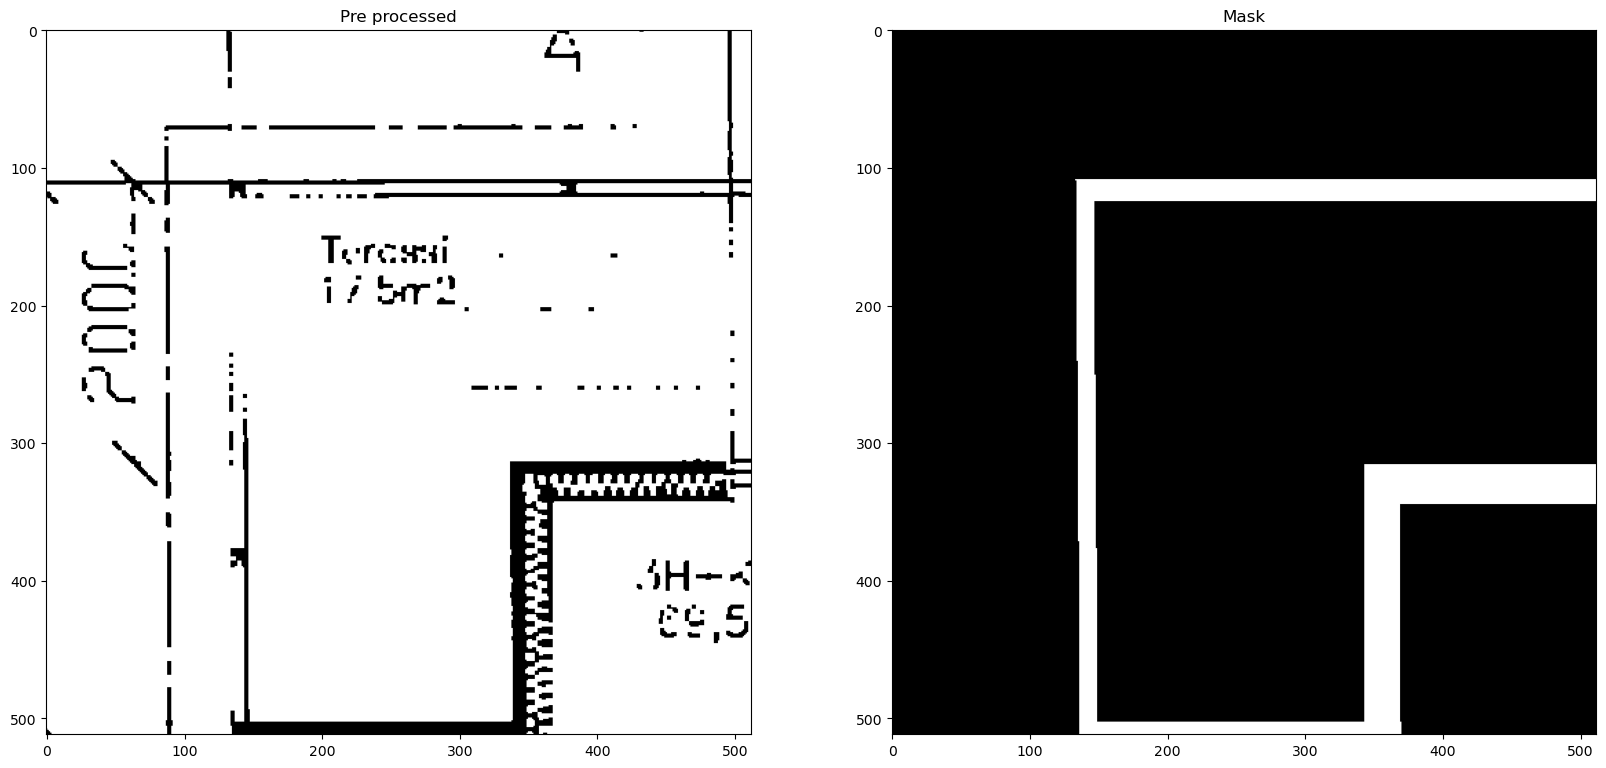

Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


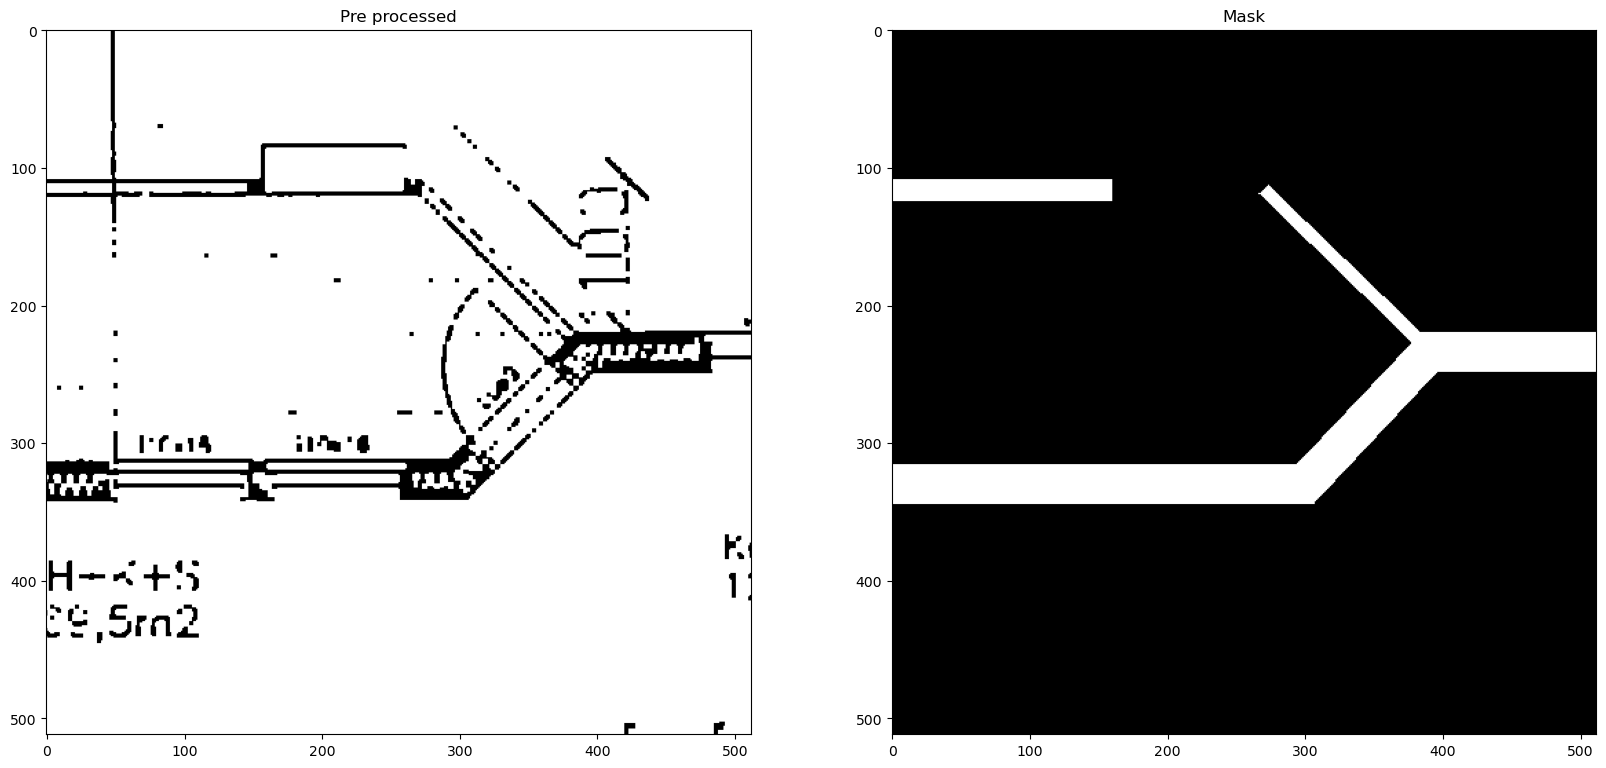

Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


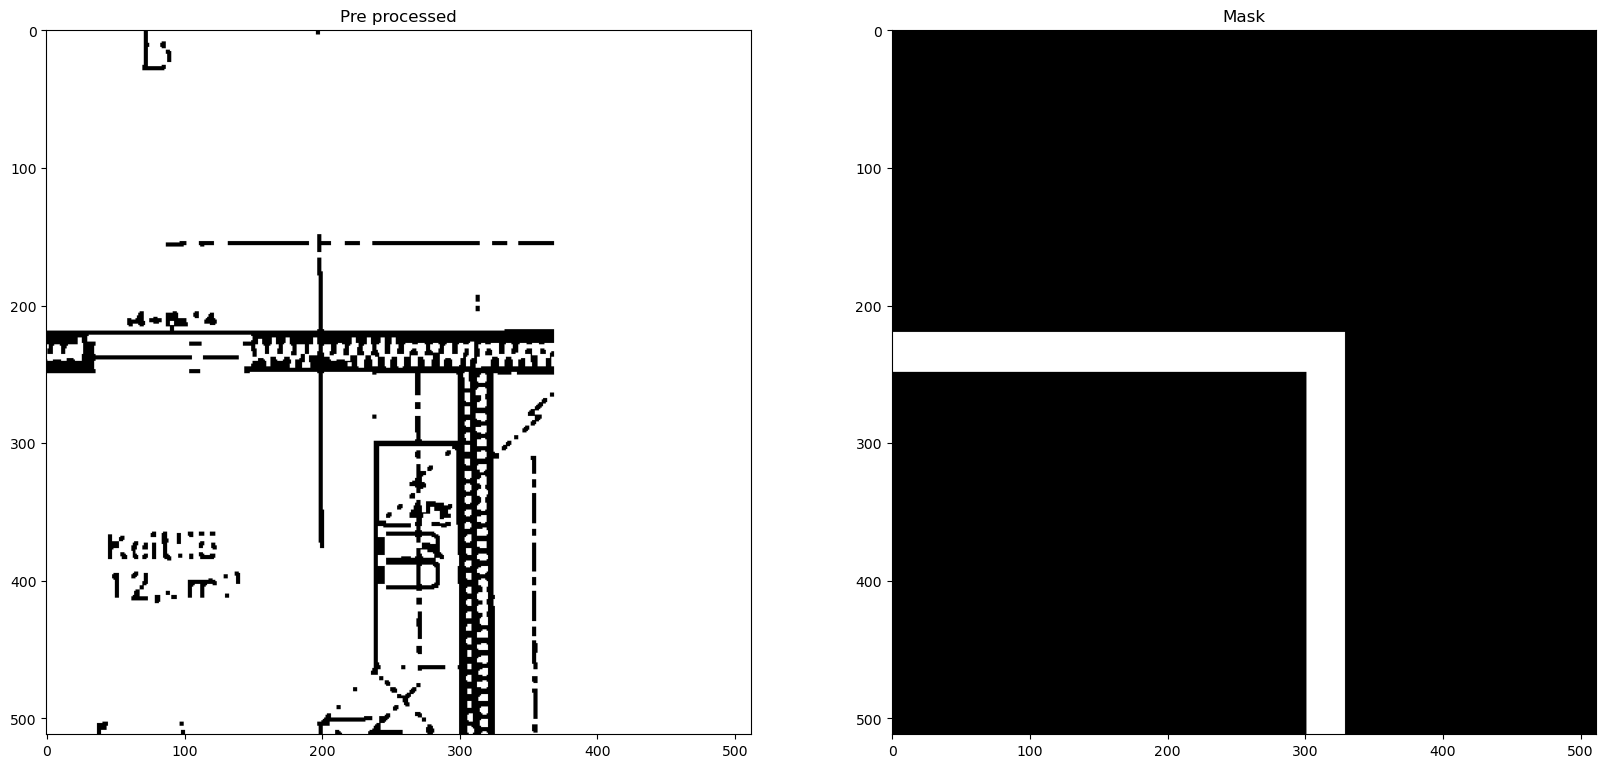

Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


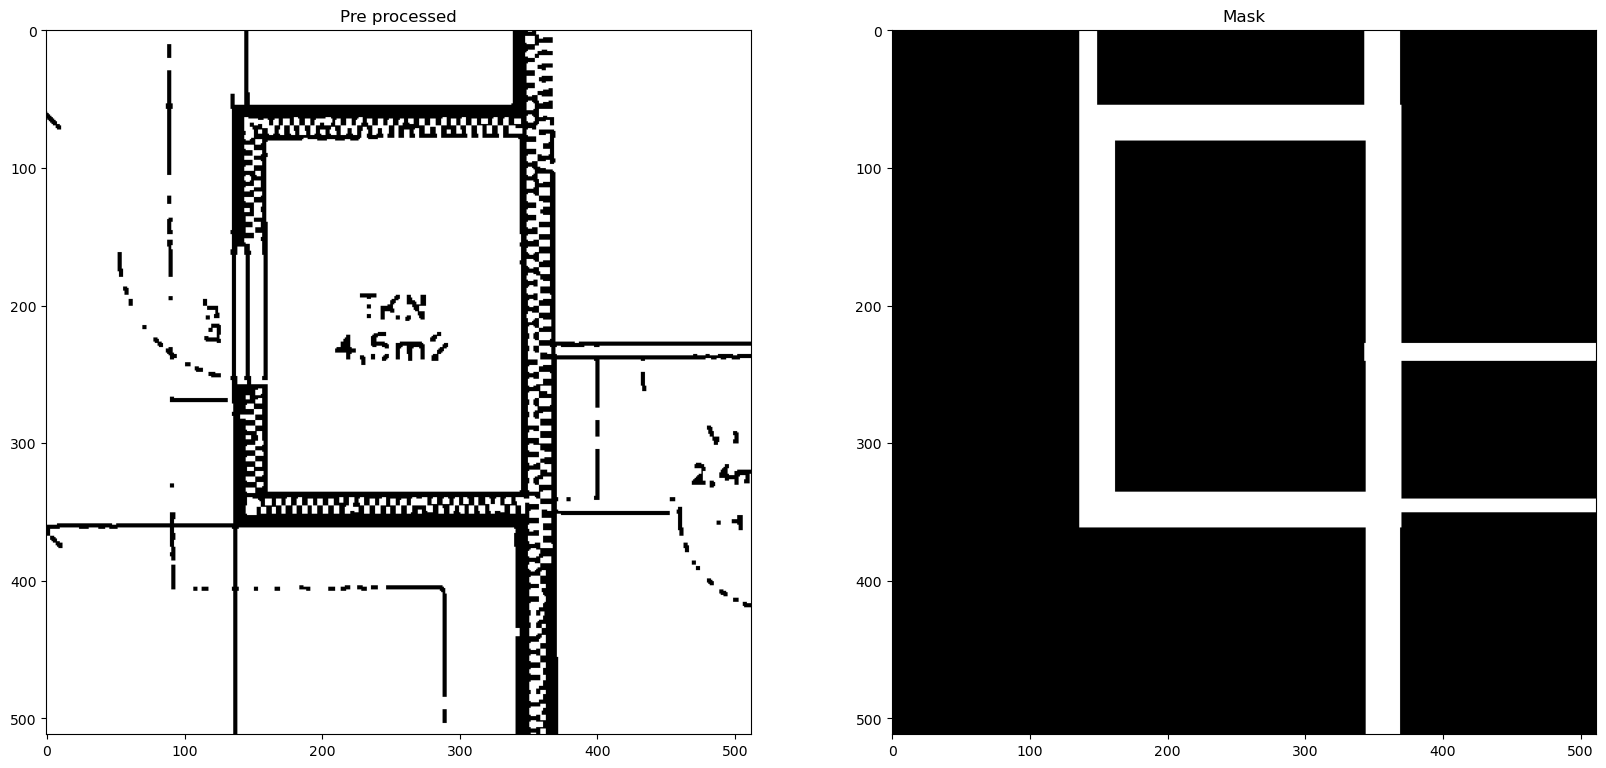

Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


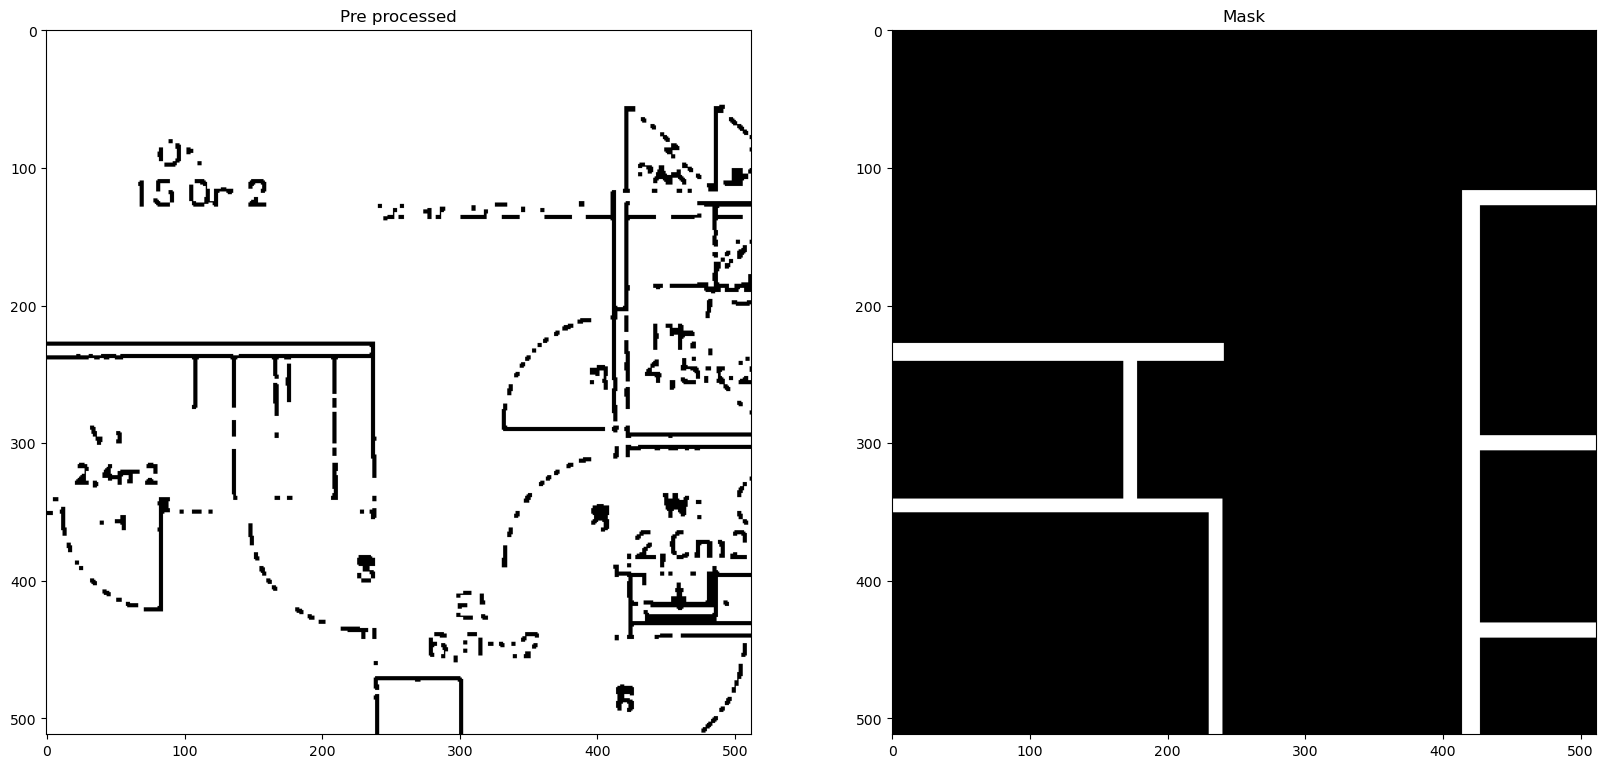

Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


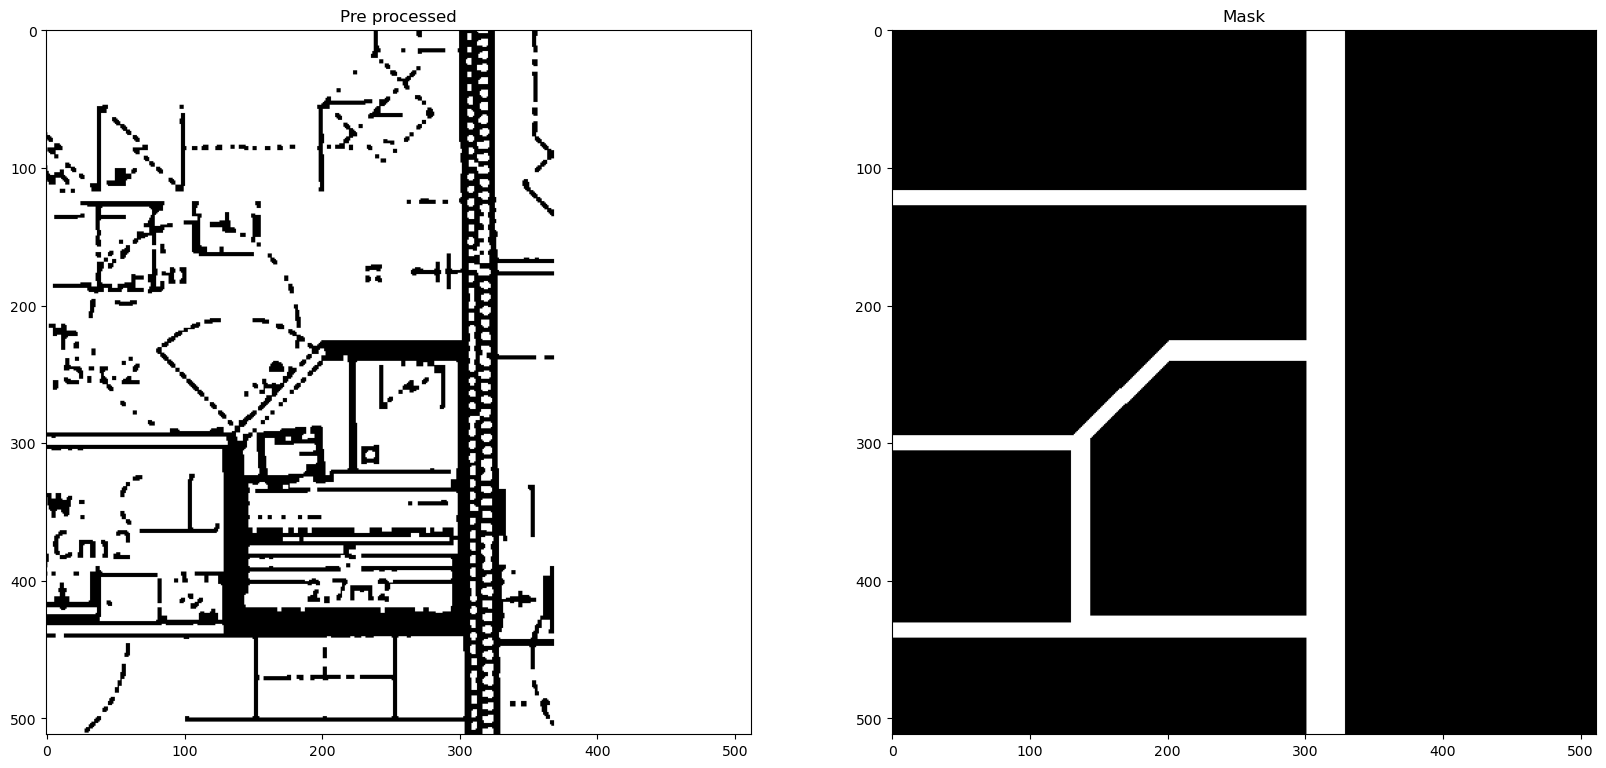

Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


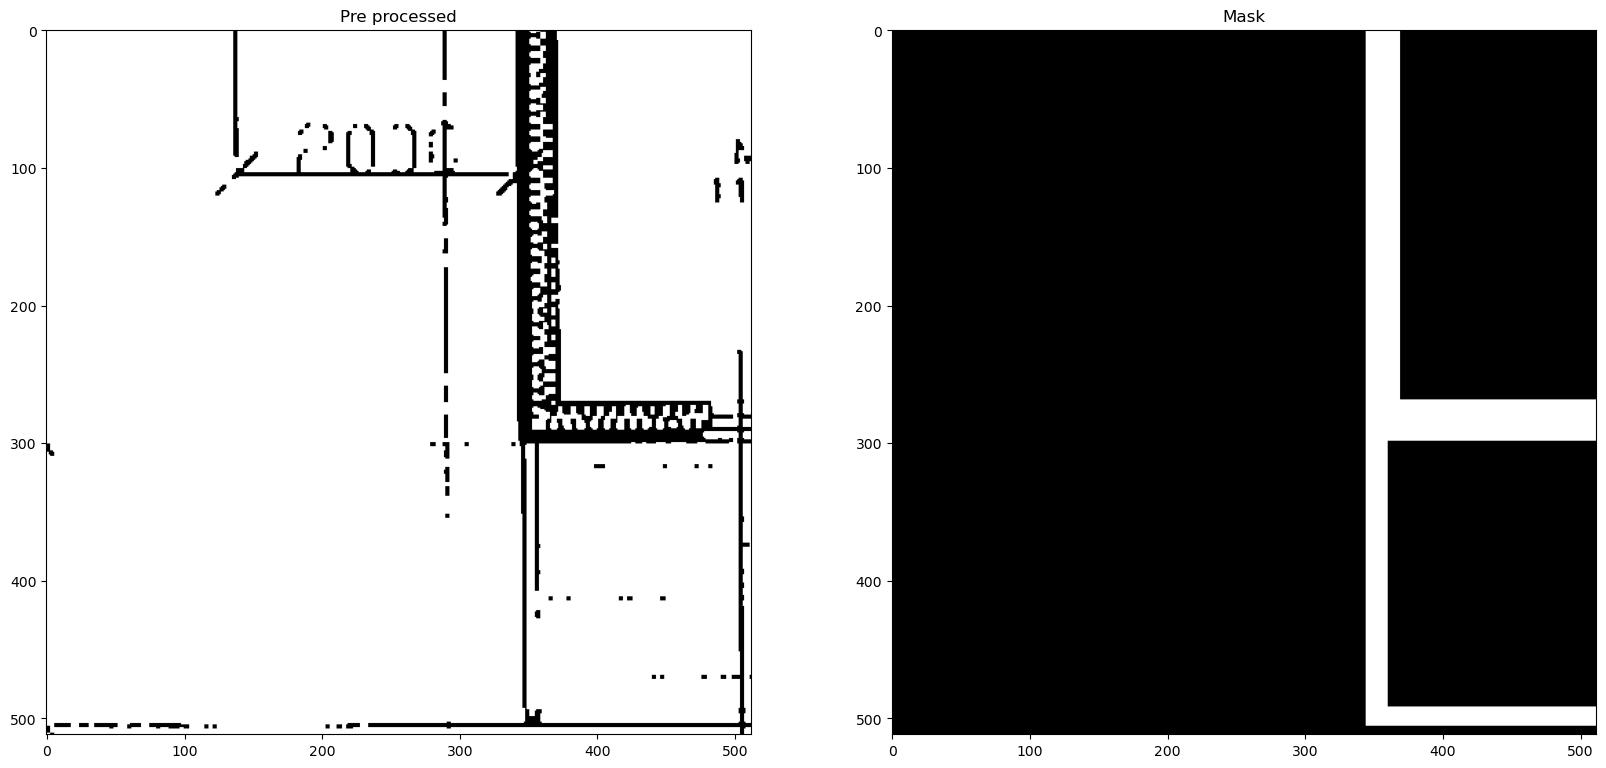

Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


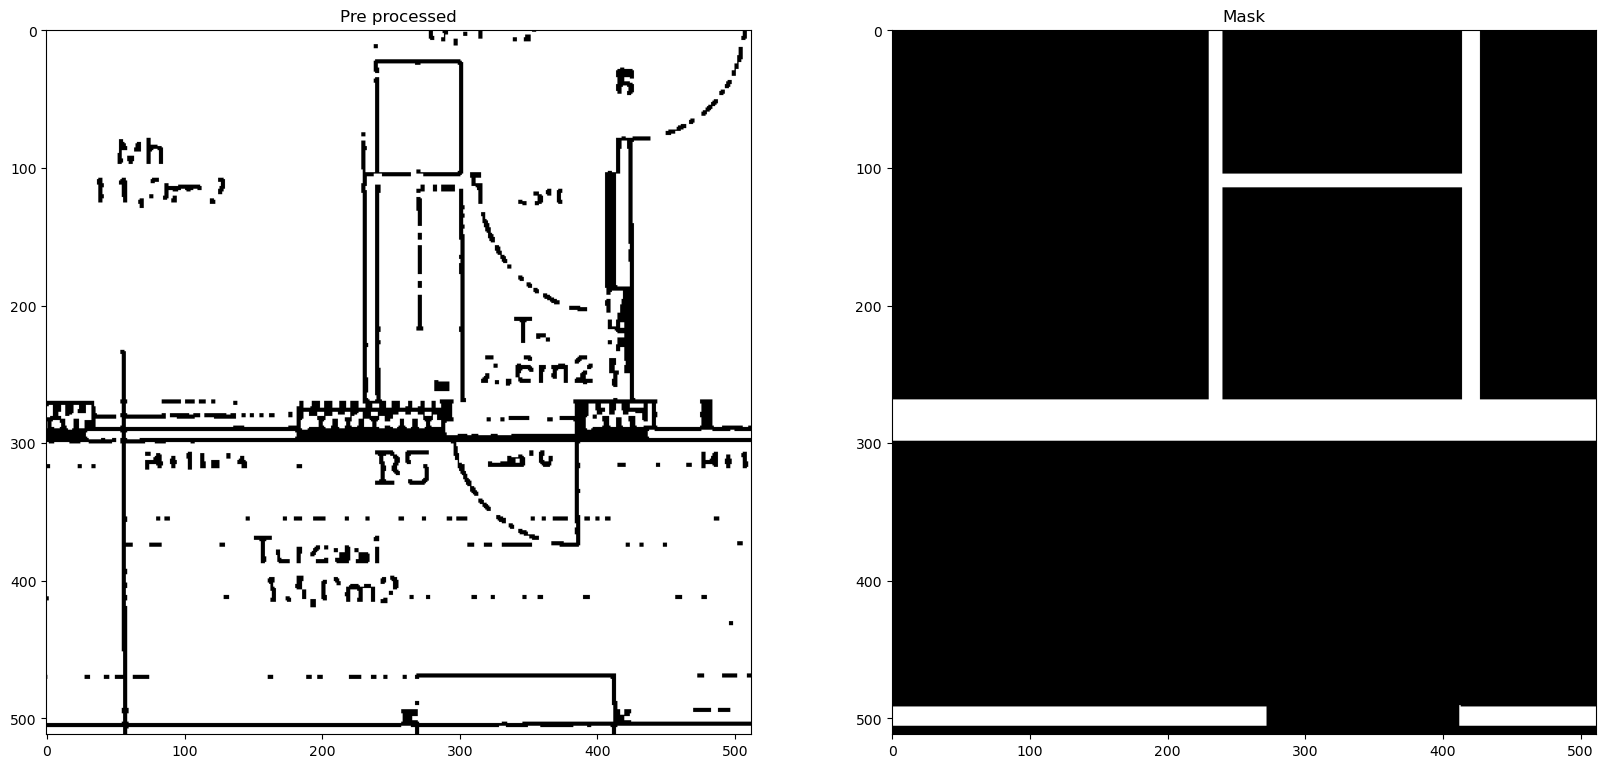

Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


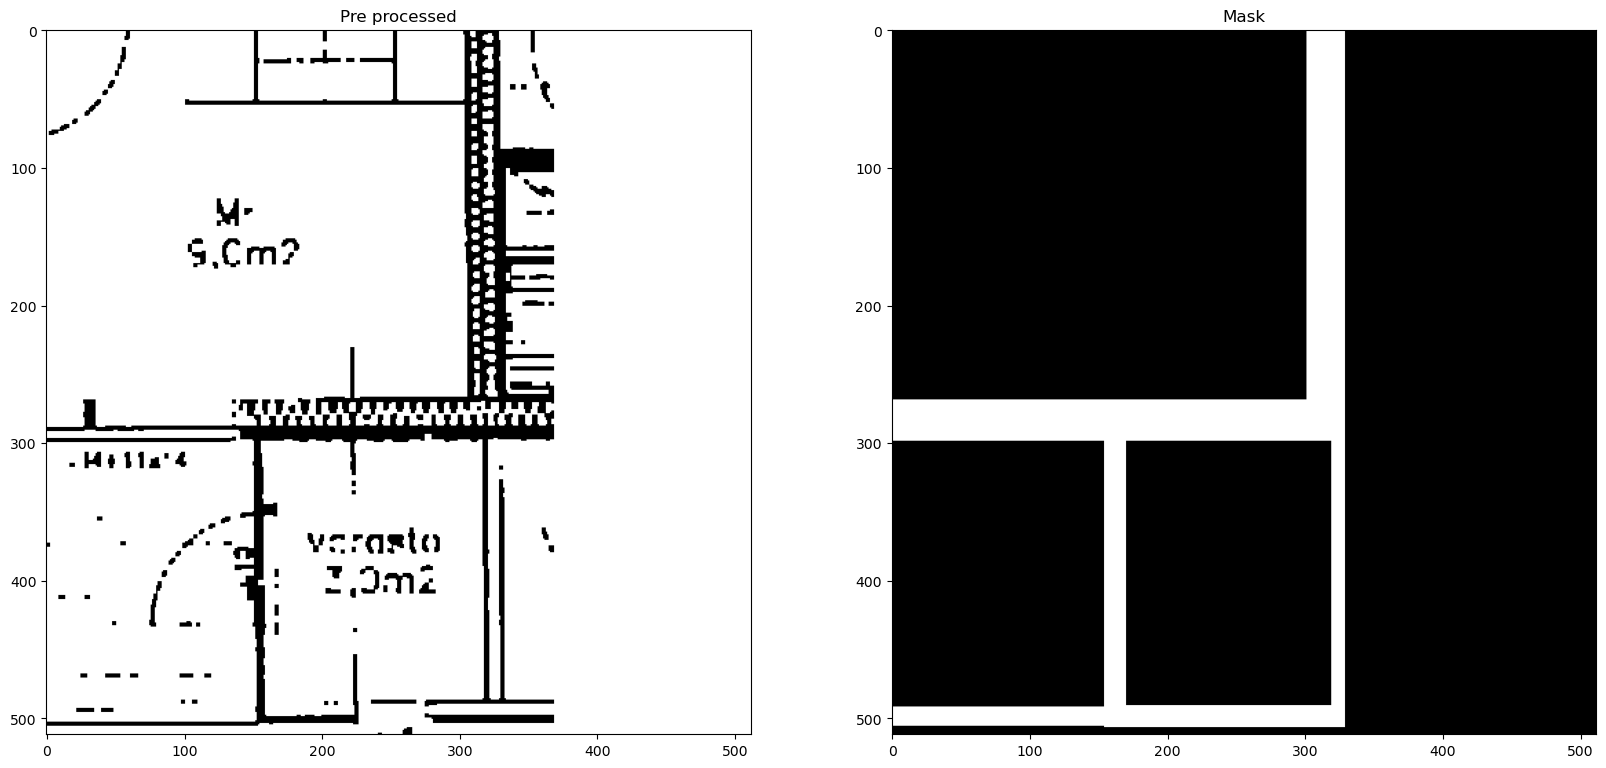

Img Shape:  torch.Size([1, 512, 512])
Mask Shape:  torch.Size([1, 512, 512])


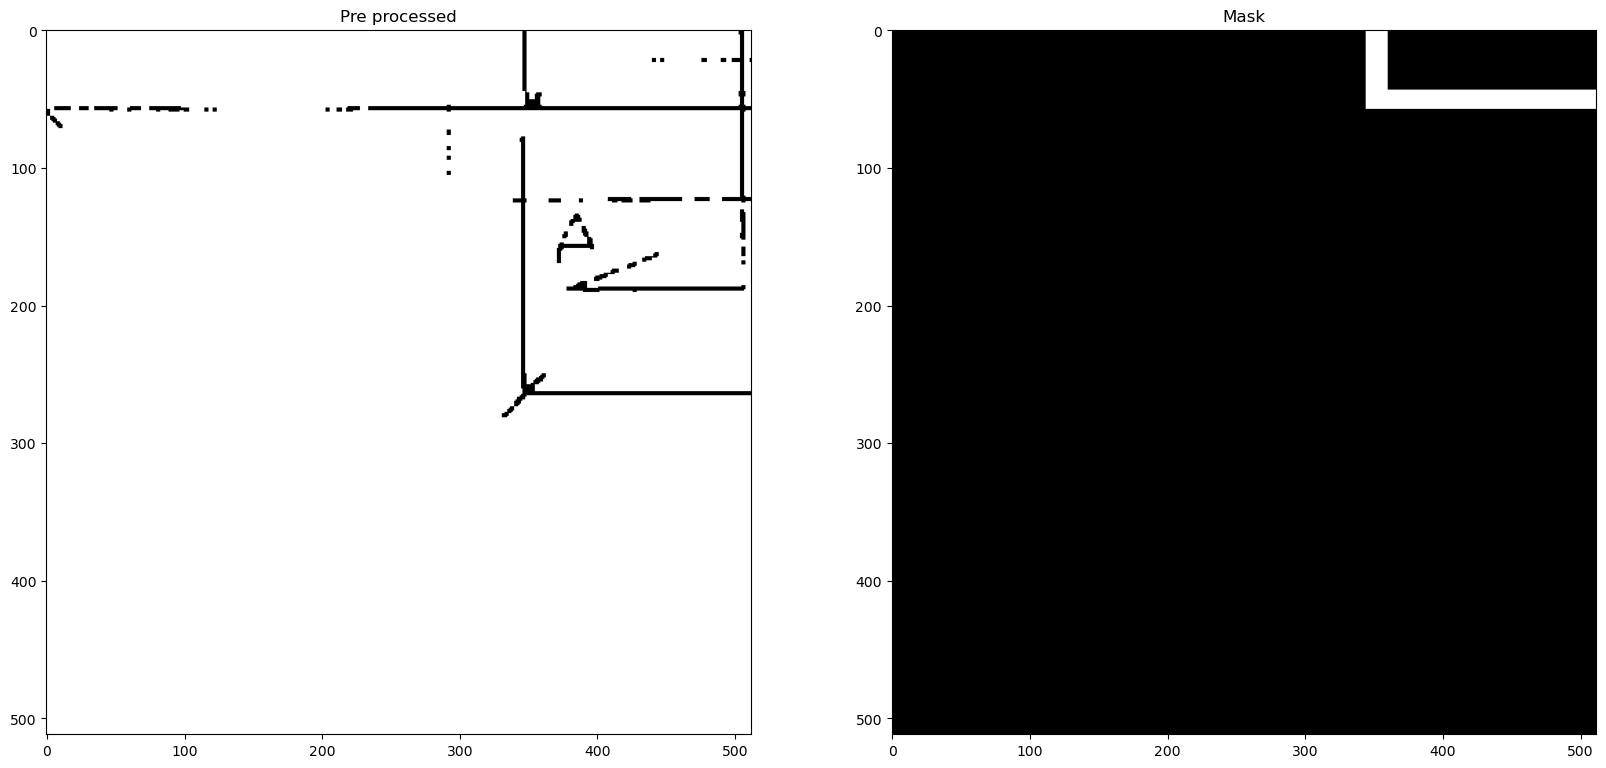

In [30]:
from random import shuffle

shuffle(train_folders)

check_pre_processer = WallSegPreprocess(
    data_folder, train_folders[:1], train_dest, "train_tensors"
)
check_pre_processer.tensorify()

check_dataset = WallSegDataset(train_dest, "train_tensors")
check_iter = iter(check_dataset)

for i in range(10):
    img, mask = next(check_iter)
    show_sample(img, mask)

In [31]:
# Preprocessing and coverting to tensors
train_pre_processer = WallSegPreprocess(
    data_folder, train_folders, train_dest, "train_tensors"
)
train_pre_processer.tensorify()

val_pre_processer = WallSegPreprocess(data_folder, val_folders, val_dest, "val_tensors")
val_pre_processer.tensorify()

Preprocessing images:   4%|▎         | 148/4200 [04:18<1:58:04,  1.75s/it]


RuntimeError: [enforce fail at alloc_cpu.cpp:118] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 44196535488 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
# Loading datasets

# Model and Loss Definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34
from torchvision.models._utils import IntermediateLayerGetter

torch.hub.set_dir(
    "/home/xfaron/Desktop/Code/Playground/test_construction/utils/torch_cache"
)  # replace with your path


class FPN(nn.Module):
    def __init__(self):
        super(FPN, self).__init__()

        backbone = resnet34(weights=None)
        return_layers = {"layer1": "c1", "layer2": "c2", "layer3": "c3", "layer4": "c4"}

        self.backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)
        out_channels = 64

        # Lateral convs
        self.lateral4 = nn.Conv2d(512, out_channels, 1)
        self.lateral3 = nn.Conv2d(256, out_channels, 1)
        self.lateral2 = nn.Conv2d(128, out_channels, 1)
        self.lateral1 = nn.Conv2d(64, out_channels, 1)

        # Output conv
        self.output_conv = nn.Conv2d(out_channels, 1, 1)

    def forward(self, x: torch.Tensor):
        x = x.repeat(1, 3, 1, 1)

        features = self.backbone(x)
        c1, c2, c3, c4 = features["c1"], features["c2"], features["c3"], features["c4"]

        p4 = self.lateral4(c4)
        p3 = self.lateral3(c3) + F.interpolate(p4, size=c3.shape[2:], mode="nearest")
        p2 = self.lateral2(c2) + F.interpolate(p3, size=c2.shape[2:], mode="nearest")
        p1 = self.lateral1(c1) + F.interpolate(p2, size=c1.shape[2:], mode="nearest")

        out = self.output_conv(F.interpolate(p1, size=x.shape[2:], mode="bilinear"))
        return out


# Kendall style learnable parameters
# L_total = L1 + alpha * L2
# But instead, we go for L_total = L1 / 2*sigma1^2 + L2 / 2*sigma2*2 + log(sigma1) + log(sigma2)
# Here, the sigma's are learnable


class MultiLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_var_bce = nn.Parameter(torch.zeros(1))
        self.log_var_aff = nn.Parameter(torch.zeros(1))

    def forward(self, bce_loss, aff_loss):
        # Uncertainty weighting
        loss = (
            1.0 / (2 * torch.exp(self.log_var_bce))
        ) * bce_loss + self.log_var_bce * 0.5
        loss += (
            1.0 / (2 * torch.exp(self.log_var_aff))
        ) * aff_loss + self.log_var_aff * 0.5
        return loss


def affinity_loss(pred):
    loss = F.binary_cross_entropy_with_logits(
        pred[:, :, 1:, :], pred[:, :, :-1, :]
    ) + F.binary_cross_entropy_with_logits(pred[:, :, :, 1:], pred[:, :, :, :-1])

    return loss

# Main Training loop

In [ ]:
from torch.utils.data import DataLoader
import itertools

device = "cuda" if torch.cuda.is_available() else "cpu"
print("On device: ", device)

training_loader = DataLoader(train_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)

model = FPN()
model = torch.nn.DataParallel(model)
model.to(device)
criterion = MultiLoss().to(device)
optimizer = torch.optim.SGD(
    itertools.chain(model.parameters(), criterion.parameters()), lr=0.001, momentum=0.9
)

In [ ]:
# One Epoch Train
def train_one_epoch(epoch_index):
    running_loss = 0
    last_loss = 0

    i = 0
    for i, data in enumerate(tqdm(training_loader)):
        img, mask = data
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()

        output_mask = model(img)

        aff_loss = affinity_loss(output_mask)
        bce_loss = F.binary_cross_entropy_with_logits(output_mask, mask)
        loss = criterion(bce_loss, aff_loss)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 500 == 499:
            last_loss = running_loss / 500
            print(f"Batch : {i + 1}, Loss : {last_loss}")

    return running_loss / i

In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

EPOCHS = 5
best_vloss = 1_000_000

exp_name = f"wall_seg_{timestamp}"
exp_folder = "/home/xfaron/Desktop/Code/Playground/test_construction/experiments"

for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch + 1}")

    # Training
    model.train(True)
    avg_loss = train_one_epoch(epoch)

    # Evaluation
    vrunning_loss = 0

    model.eval()
    with torch.no_grad():
        for i, vdata in val_loader:
            vimg, vmask = vdata
            vimg, vmask = vimg.to(device), vmask.to(device)

            output_mask = model(vimg)

            aff_loss = affinity_loss(output_mask)
            bce_loss = F.binary_cross_entropy_with_logits(output_mask, vmask)
            vloss = criterion(bce_loss, aff_loss)

            vrunning_loss += vloss

    avg_vloss = (vrunning_loss) / (i + 1)
    print(f"LOSS > Train : {avg_loss}, Val : {avg_vloss}")

    if avg_loss < best_vloss:
        best_vloss = avg_vloss
        model_path = os.path.join(exp_folder, exp_name, f"model_{epoch}_{best_vloss}")
        torch.save(model.state_dict(), model_path)

# Validation

In [ ]:
from random import shuffle

test_file = "/kaggle/input/cubicasa5k/cubicasa5k/cubicasa5k/test.txt"

test_folder = []
with open(test_file) as file:
    test_folders = file.read().split("\n")


WallSegDataset(data_folder, test_folders[:2]).pre_process()